##  Visualizing and Understanding CNNs

**Team: Square**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/My Drive/SMAI/Understanding_CNN"

Mounted at /content/drive
/content/drive/My Drive/SMAI/Understanding_CNN


### Saliency Maps

In [2]:
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils

import numpy as np
import scipy.misc
%matplotlib inline
from PIL import Image
import json

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# model = models.vgg16(pretrained=True)
model = models.resnet152(pretrained=True)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
def create_sm(image):

    transform = transforms.Compose([
		transforms.Resize(256),
		transforms.CenterCrop(224),
		transforms.ToTensor(),
    ])
    image = transform(image)
    image = image.reshape(1, 3, 224, 224)
    image = image.to(device)
    image.requires_grad_()

    out = model(image)

    torch.max(out,dim=1)[0].backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
    saliency = saliency.reshape(224, 224)

    image = image.reshape(-1, 224, 224)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(saliency.cpu(), cmap='hot')
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle('Saliency Map')
    plt.show()

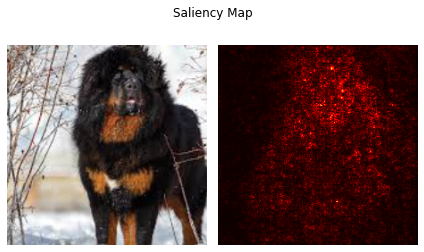

In [38]:
image = Image.open('imgs/tm_imagenet.jpeg')
create_sm(image)

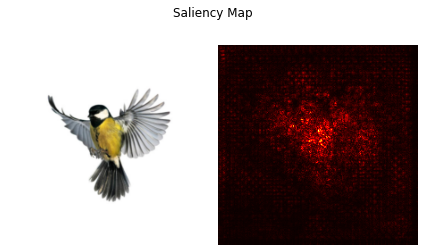

In [35]:
image = Image.open('imgs/bird.jpg')
create_sm(image)

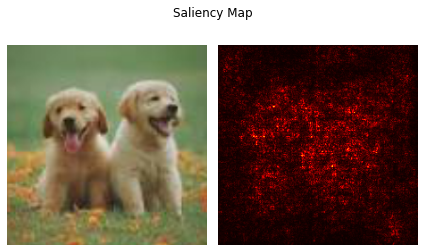

In [37]:
image = Image.open('imgs/dogs.jpeg')
create_sm(image)

### Visualizing CNN layer's weights

In [39]:
import numpy as np
from math import ceil, sqrt

def visualize_grid(Xs, ubound=255.0, padding=1):
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

torch.Size([64, 3, 7, 7])
(64, 7, 7, 3)
(63, 63, 3)


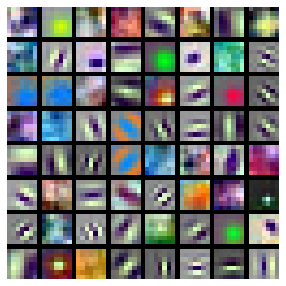

In [40]:
print(model.conv1.weight.shape)
a = model.conv1.weight
a = a.cpu().detach().numpy()
a = a.transpose(0, 2, 3, 1)
print(a.shape)
grid = visualize_grid(a)
print(grid.astype('uint8').shape)
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

### Visualizing feature maps

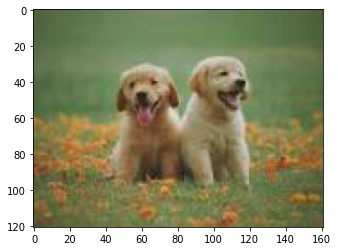

In [ ]:
image = Image.open('imgs/dogs.jpeg')
plt.imshow(image)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

In [ ]:
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [ ]:
model_weights =[]
conv_layers = []
model_children = list(model.children())
counter = 0
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 151
conv_layers


In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
for feature_map in outputs:
    print(feature_map.shape)

151
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])
torch.Size([1, 128, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 

In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    # print(feature_map.shape)
    # gray_scale = feature_map[0]
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    # print(feature_map.shape, gray_scale.shape)
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 2

ValueError: ignored

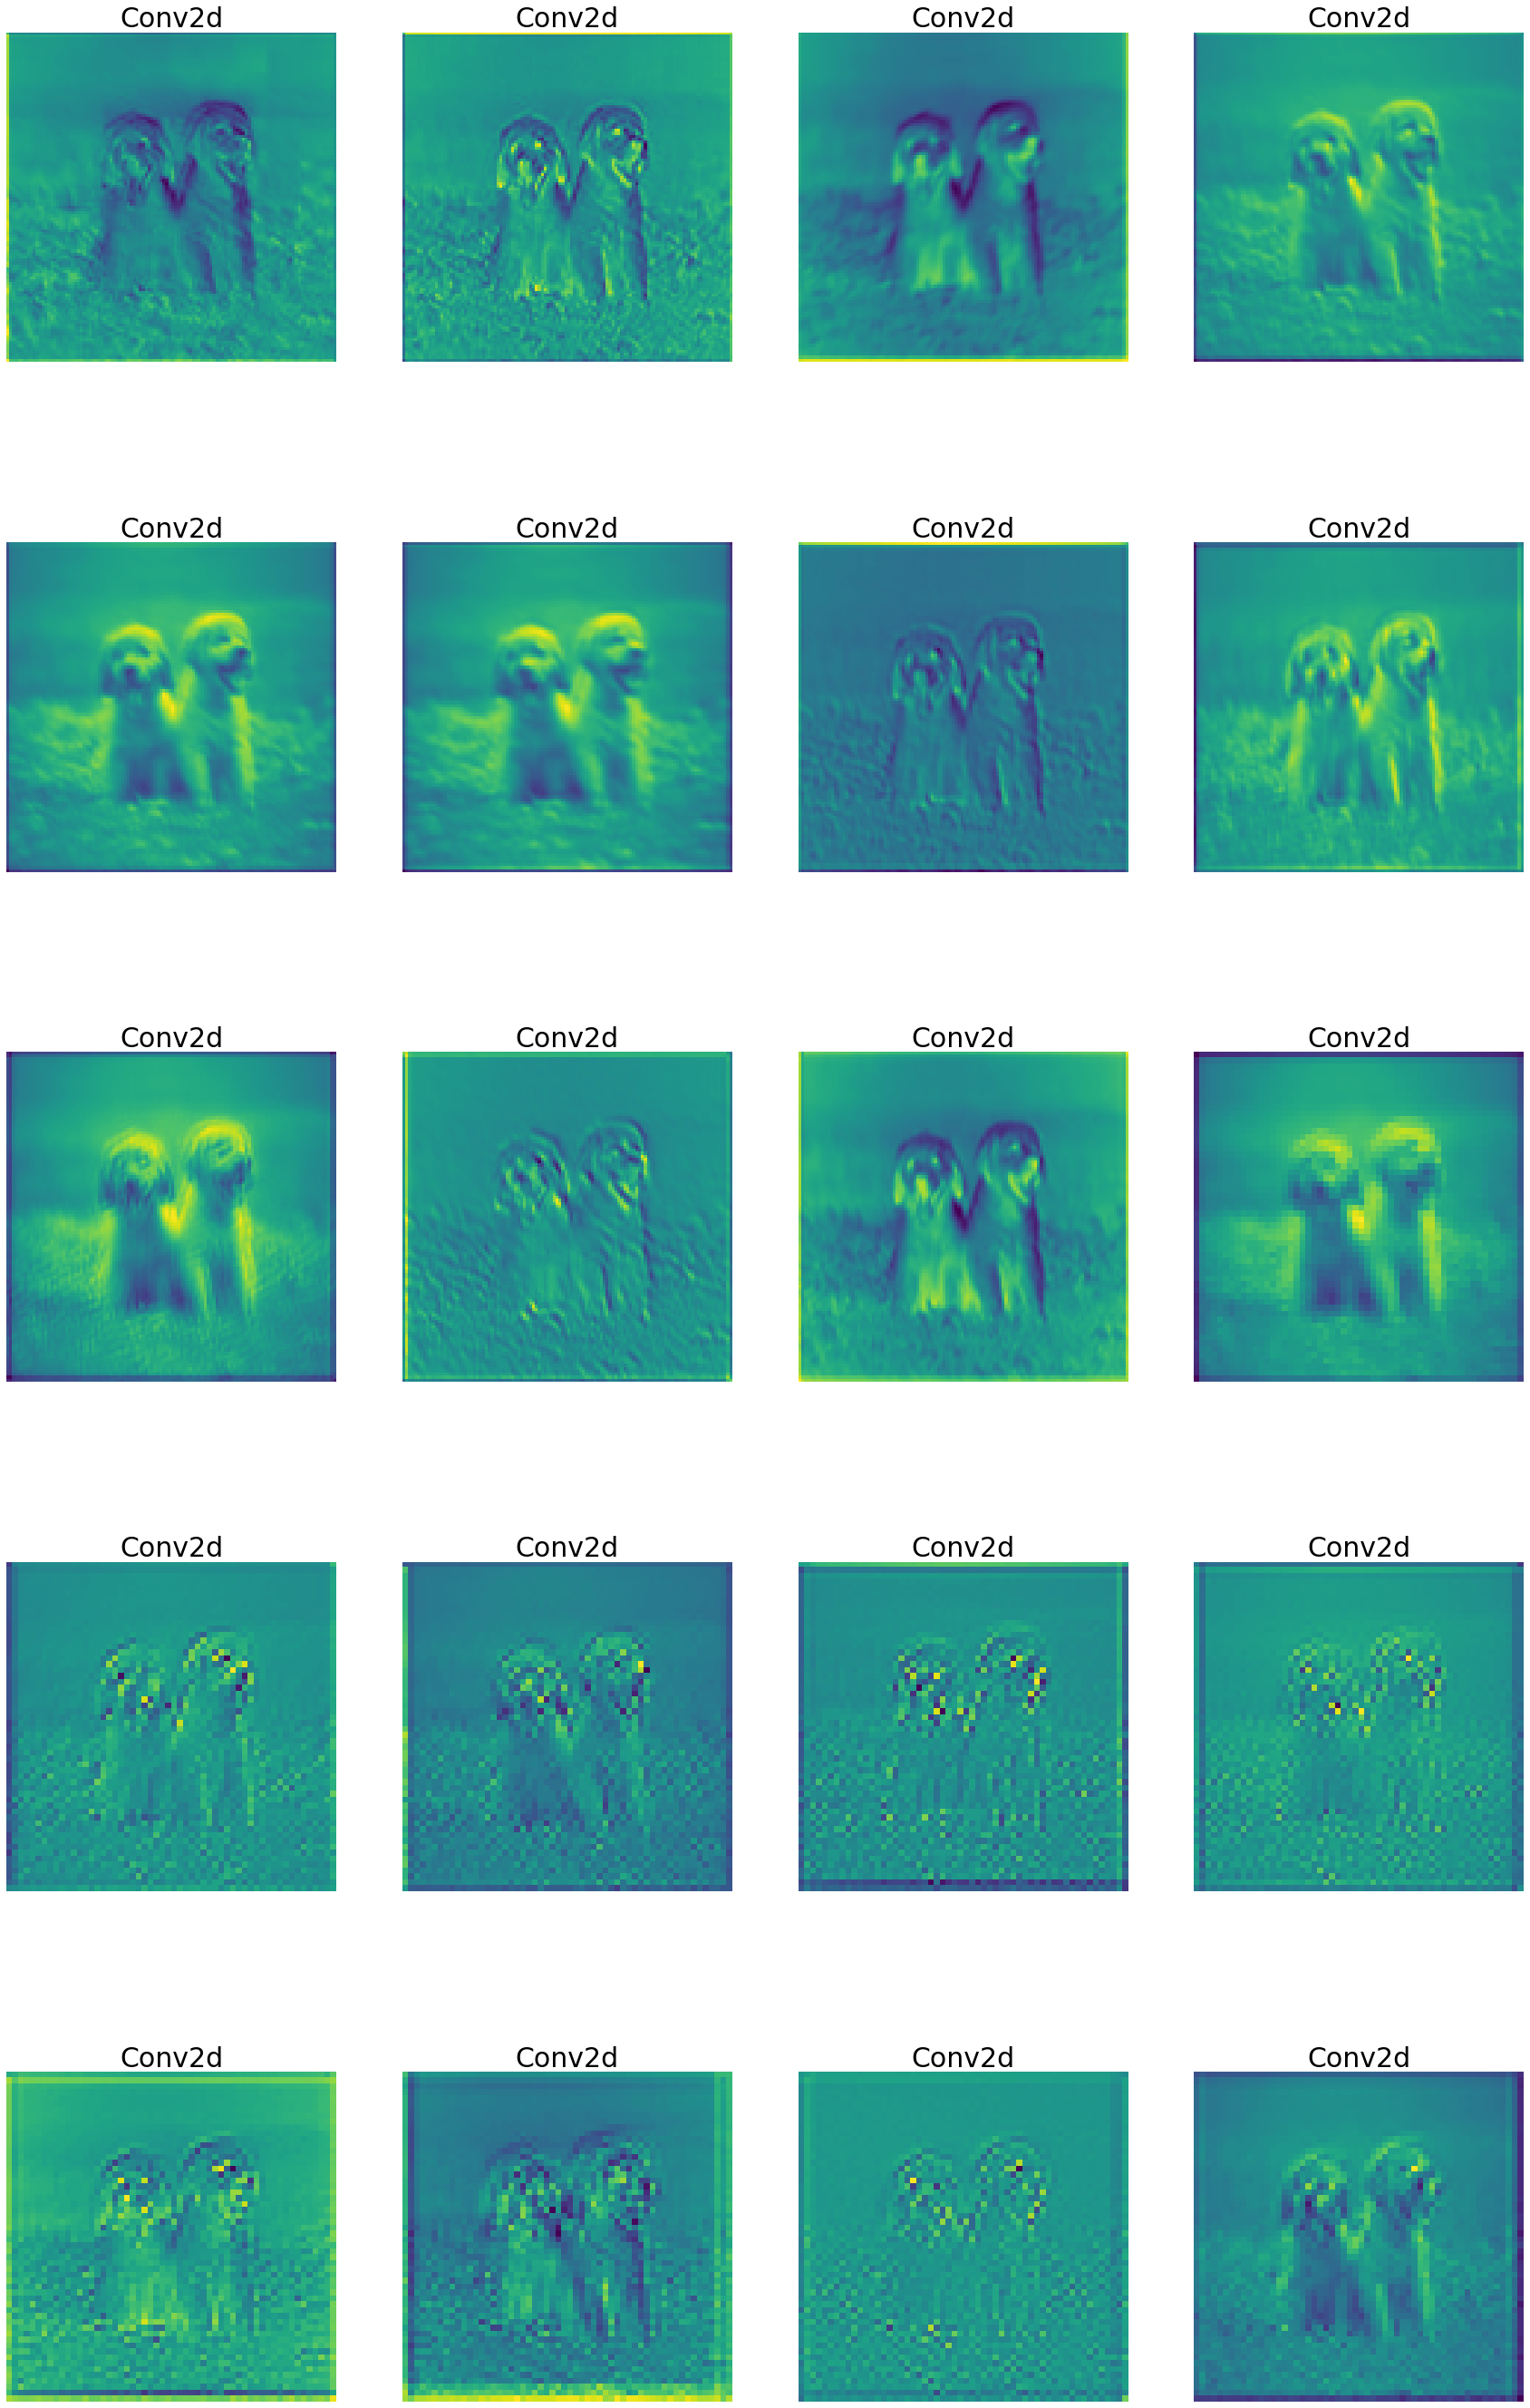

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)

In [4]:
def normalize(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0).cuda())
    return image


def predict(image):
    _, index = vgg(image).data[0].max(0)
    # print(index)
    # print(type(index))
    # print(index.shape)
    return str(index.item()), labels[str(index.item())][1]
    
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

In [6]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()
labels = json.load(open('labels/imagenet_class_index.json'))

dog = Image.open("imgs/dogs.jpeg")

dog = normalize(dog)
print(predict(dog))
modulelist = list(vgg.features.modules())

('207', 'golden_retriever')


In [12]:
def create_heatmap(image, true_class, k, stride): 
    heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), int(((image.shape[3]-k)/stride)+1))
    image = image.data

    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.ones(image.shape)
            h_filter[:,:,j:j+k, i:i+k] = 0
            temp_image = Variable((image.cuda() * h_filter.cuda()).cuda())
            temp_softmax = vgg(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            j += stride
            b += 1
        i += stride
        a += 1
    
    image = image.squeeze()
    
    true_image = image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)
    
    a = fig.add_subplot(1,2,1)
    true_image = true_image.cpu().numpy()

    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 
    
    heatmap = heatmap - heatmap.min()
    heatmap = np.uint8(255 * heatmap)
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off') 
    
    return heatmap

In [25]:
my_img = Image.open("imgs/new_fish.jpg")
my_img = normalize(my_img)
print(predict(my_img))
print(int(predict(my_img)[0]))

('1', 'goldfish')
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


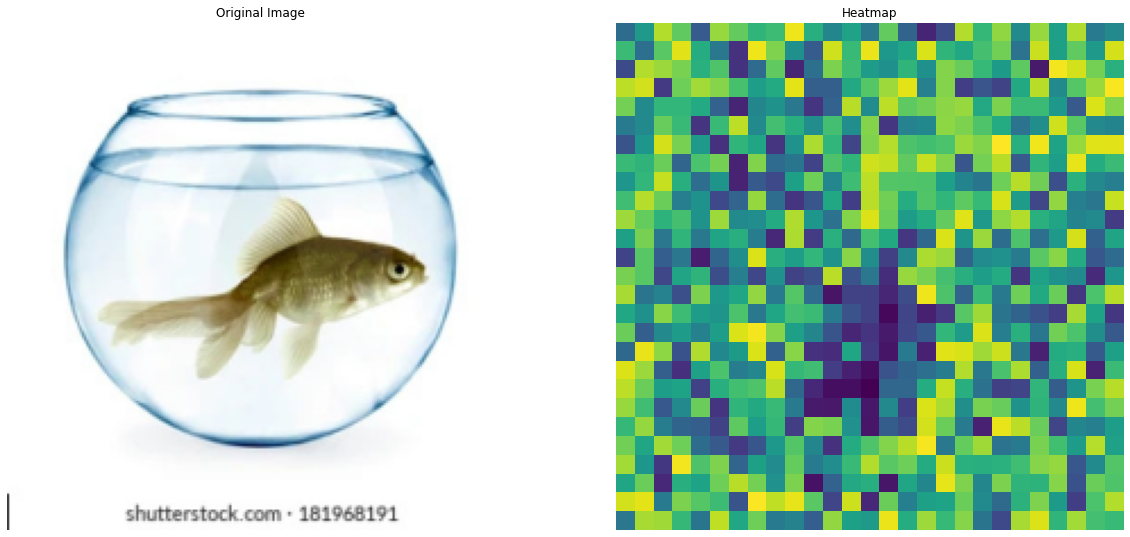

In [26]:
dog_heatmap = make_heatmap(my_img, 1,16,8)